In [1]:
import sqlite3
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from skimage import io, data, color
import re
from re import findall,UNICODE

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression as logreg
from sklearn.linear_model import LogisticRegressionCV as logregcv
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import Imputer
from scipy.stats import ttest_ind as ttest
from scipy.stats import ttest_rel
from statsmodels.sandbox.stats.multicomp import multipletests

from labMTsimple.speedy import *
from bgfunc import *

import warnings
warnings.filterwarnings("ignore")


/Users/andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load SQLite database 

In [2]:
dbfile = 'project_may9_649pm.db'
conn = sqlite3.connect(dbfile)

## Analysis parameters 

Which condition are we studying?  Are there any cutoffs based on testing?

In [3]:
platform = 'ig' # ig, tw
platform_long = 'instagram' # instagram, twitter
condition = 'depression' # depression, pregnancy, cancer, ptsd
test_name = 'cesd' # cesd or tsq or ''
test_cutoff = 21 # 21 for cesd, 5 for tsq (we do > not >= comparison)
photos_rated = True # this sets the optional "ratings_ct >= ratings_min" inside define_params() 
has_test = True
gb_types = ['post','username','created_date']
periods = ['before','after']
turn_points = ['from_diag','from_susp']
fields = "url" # "url" for instagram, "text, id" for twitter

In [4]:
params = define_params(condition, test_name, test_cutoff, 
                       platform, platform_long, fields, 
                       photos_rated, has_test)

In [5]:
data = make_data_dict(params, condition, test_name, conn)

## Sample sizes across all conditions

In [7]:
report_sample_sizes(params, conn, condition, platform_long, test_cutoff, test_name)

SAMPLE SIZES: target populations

TARGET :: DEPRESSION / INSTAGRAM total: 88
TARGET :: DEPRESSION / INSTAGRAM cesd > 21: 74


SAMPLE SIZES: control populations

CONTROL :: DEPRESSION / INSTAGRAM total: 100



# To-Do May 10 
### Find out how many individuals are represented in correct vs incorrect predictions
Eg. do we get some users who always show up in false neg or false pos, or in true pos?  
This might be especially useful for the url and created date analyses, where we don't know the extent to which a subset of usernames might be driving correct classification.  
for those in false pos, look at the actual posts (might be easier for twitter), and maybe even have mturk rate whether they seem depressed or not. are we finding new depressed cases, or are we just wrong?  

### Restrict username analysis to only those individuals with a minimum number of days represented in their observations 
Alternately, min number of posts   
See R code notes for more. (bayes.R)

### Move R code to Jupyter?

## Social Media Analysis

In [6]:
do_print = False # for notebook-format report printout of exploratory/data cleaning functions

In [7]:
# collect target and control data
for pop, pop_long in [('t','target'),('c','control')]:
    
    # get hsv data
    get_basic_data(data, platform, params, conn, pop, pop_long)
    
    # this if- block deals with conditions where photos have been rated
    if params['rated']: 
        
        kind = 'ratings'
        
        d = get_photo_ratings(params, conn, pop)

        # print 'Indices with broken photos:', find_and_drop_broken_photos(d, drop_from_df=False)
        find_and_drop_broken_photos(d) # this call actually drops them

        d2 = get_meta(params, conn, pop)

        # Now merge the meta_ig data with the photo_ratings_depression data
        consolidate_data(d, d2, platform, pop_long, kind, data)
        
        if do_print:
            # Hunting for ratings errors
            print_coltype(data, condition, platform, pop)
            ixs = find_chartype(data,'interesting')

        ''' Warning: This isn't very robust - you have this conditional set here because you discovered it's only the 
            target group photo ratings that have the problematic "strings for photo ratings" issue.  

            A more generalized way to go about this would be to create a flag from find_chartype() that identifies whether 
            map_str_ratings_to_numeric() is necessary...but even then, the custom mapping you created is really case specific 
            and does not easily generalize. 
            
            It's probably not worth trying to generalize these functions for the purposes of your dissertation research. '''

        if pop_long == 'target':
            map_str_ratings_to_numeric(data) 

        if do_print:
            # Check fixed ratings 
            print_coltype(data, condition, platform, pop=pop)

        # And now merge ratings data with hsv data
        consolidate_data(data[pop_long][kind], data[pop_long]['hsv'], platform, pop_long, 'all', data)
    
    
    # aggregate data by groupby types (url, username, created_date)
    make_groupby(data[pop_long], platform, pop_long, params, gb_types)
    

    if pop_long == 'target':
        # creates before/after subsets for target pop
        # subsets stored in: data[m]['target'][period][turn_point]['all']
        make_timeline_subsets(data, platform, periods)
    
        for period in periods:
            for turn_point in turn_points:
                # aggregate data by groupby types (url, username, created_date)
                make_groupby(data[pop_long][period][turn_point], platform, pop_long, params, gb_types,
                             period = period, turn_point=turn_point)

Shape of consolidated TARGET RATINGS data: (22860, 17)
Shape of consolidated TARGET ALL data: (22860, 20)

Shape of consolidated CONTROL RATINGS data: (22338, 17)
Shape of consolidated CONTROL ALL data: (22338, 20)


In [12]:
save_to_file = False # to save locally to csv
density = True # to plot target vs control per-variable densities
corr = True # correlation matrix heatmap
ml = False # to run machine learning models
nhst = True # for NHST t-tests


Merge to master: MAIN post
target vs control for IG POST-groupby:


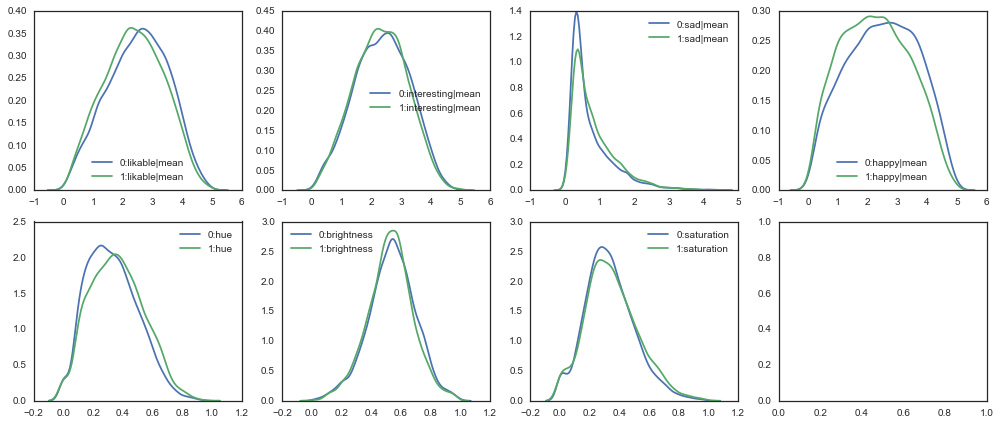

Correlation matrix:


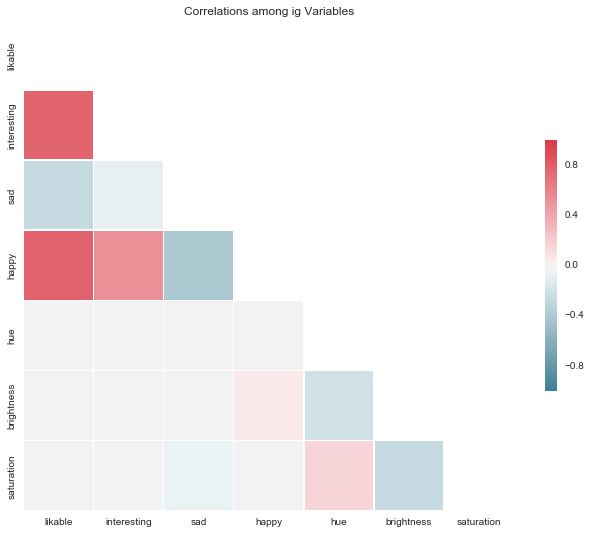

             likable  interesting   sad  happy   hue  brightness  saturation
likable         1.00         0.77 -0.27   0.78 -0.00        0.03       -0.01
interesting     0.77         1.00 -0.08   0.52 -0.01        0.02       -0.02
sad            -0.27        -0.08  1.00  -0.40 -0.02       -0.03       -0.07
happy           0.78         0.52 -0.40   1.00  0.01        0.05        0.02
hue            -0.00        -0.01 -0.02   0.01  1.00       -0.21        0.16
brightness      0.03         0.02 -0.03   0.05 -0.21        1.00       -0.26
saturation     -0.01        -0.02 -0.07   0.02  0.16       -0.26        1.00
UNIT OF MEASUREMENT: post

RATING: likable|mean
Ttest_indResult(statistic=7.6609682406496598, pvalue=1.9739182271215846e-14)

RATING: interesting|mean
Ttest_indResult(statistic=3.0369434190901408, pvalue=0.0023945742542546482)

RATING: sad|mean
Ttest_indResult(statistic=-8.1366807812784039, pvalue=4.4245714960660479e-16)

RATING: happy|mean
Ttest_indResult(statistic=11.431837882869

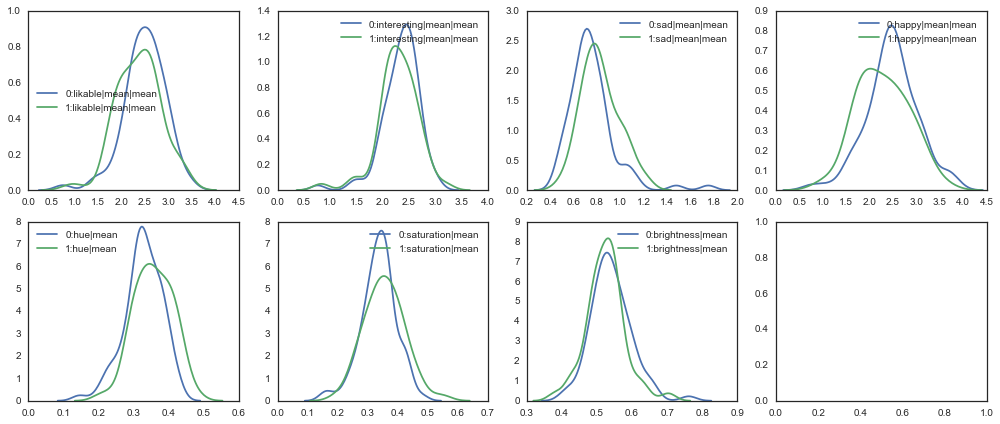

Correlation matrix:


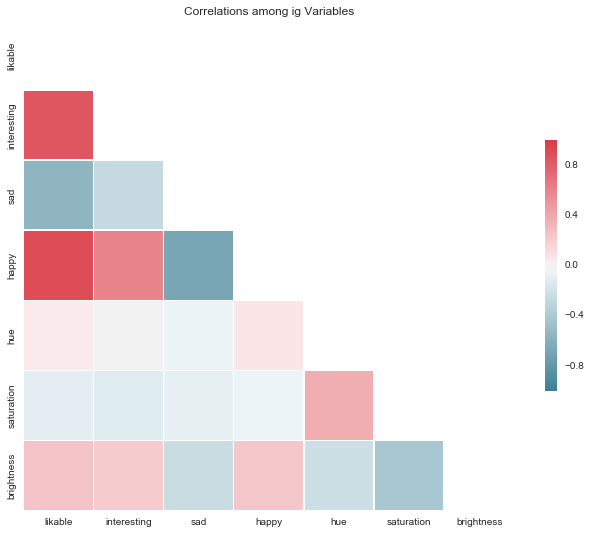

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.85 -0.56   0.90  0.04       -0.10        0.25
interesting     0.85         1.00 -0.27   0.60 -0.01       -0.12        0.21
sad            -0.56        -0.27  1.00  -0.68 -0.06       -0.08       -0.25
happy           0.90         0.60 -0.68   1.00  0.07       -0.05        0.23
hue             0.04        -0.01 -0.06   0.07  1.00        0.37       -0.22
saturation     -0.10        -0.12 -0.08  -0.05  0.37        1.00       -0.42
brightness      0.25         0.21 -0.25   0.23 -0.22       -0.42        1.00
UNIT OF MEASUREMENT: username

RATING: likable|mean|mean
Ttest_indResult(statistic=1.5165575445158432, pvalue=0.13178785352597505)

RATING: interesting|mean|mean
Ttest_indResult(statistic=0.89537837228769812, pvalue=0.37222712968055605)

RATING: sad|mean|mean
Ttest_indResult(statistic=-2.1381698183958617, pvalue=0.034359324756836583)

RATING: happy|mean|mean
Ttest_indResult(statist

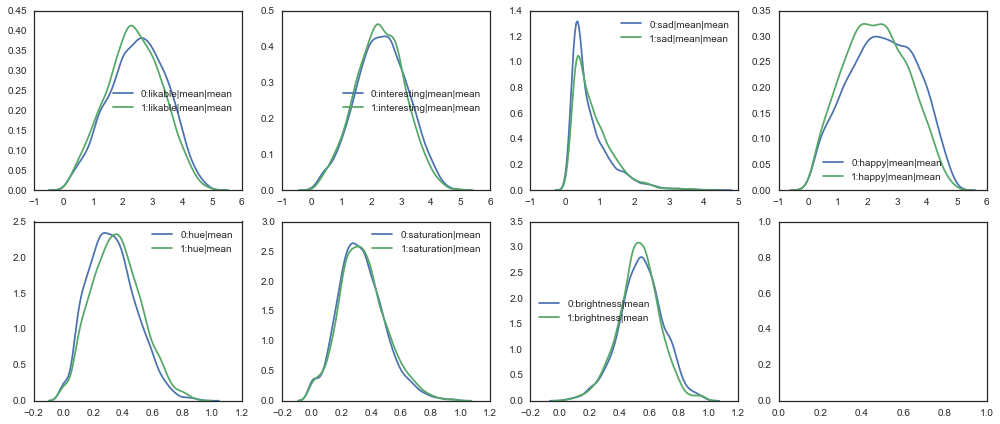

Correlation matrix:


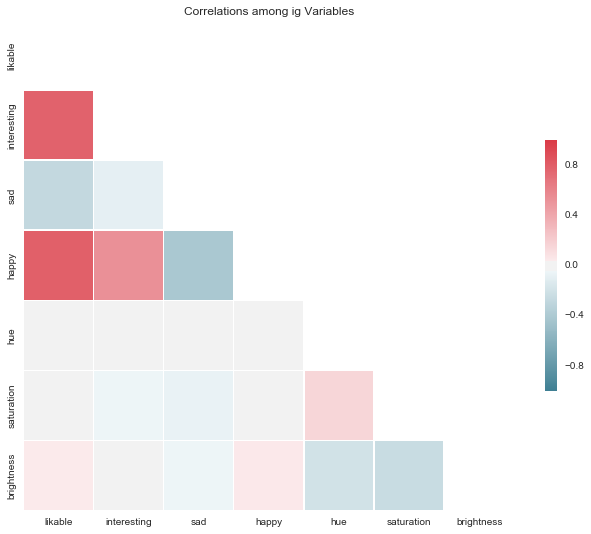

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.78 -0.28   0.79 -0.00       -0.02        0.04
interesting     0.78         1.00 -0.09   0.53 -0.03       -0.04        0.03
sad            -0.28        -0.09  1.00  -0.41 -0.02       -0.07       -0.04
happy           0.79         0.53 -0.41   1.00  0.02        0.02        0.05
hue            -0.00        -0.03 -0.02   0.02  1.00        0.15       -0.20
saturation     -0.02        -0.04 -0.07   0.02  0.15        1.00       -0.25
brightness      0.04         0.03 -0.04   0.05 -0.20       -0.25        1.00
UNIT OF MEASUREMENT: created_date

RATING: likable|mean|mean
Ttest_indResult(statistic=6.2671957080973719, pvalue=3.845334704367339e-10)

RATING: interesting|mean|mean
Ttest_indResult(statistic=3.1761786032014165, pvalue=0.001497342543453839)

RATING: sad|mean|mean
Ttest_indResult(statistic=-6.1389614704184954, pvalue=8.6584853330790957e-10)

RATING: happy|mean|mean
Ttest_indResult

In [13]:
master = data['master']
target = data['target']['gb']
control = data['control']['gb'] 
m = platform
report = 'MAIN'

master_actions(master, target, control, condition,
               m, params, gb_types, report,
               save_to_file, density, corr, ml, nhst)


Merge to master: before from_diag post
target vs control for IG POST-groupby:


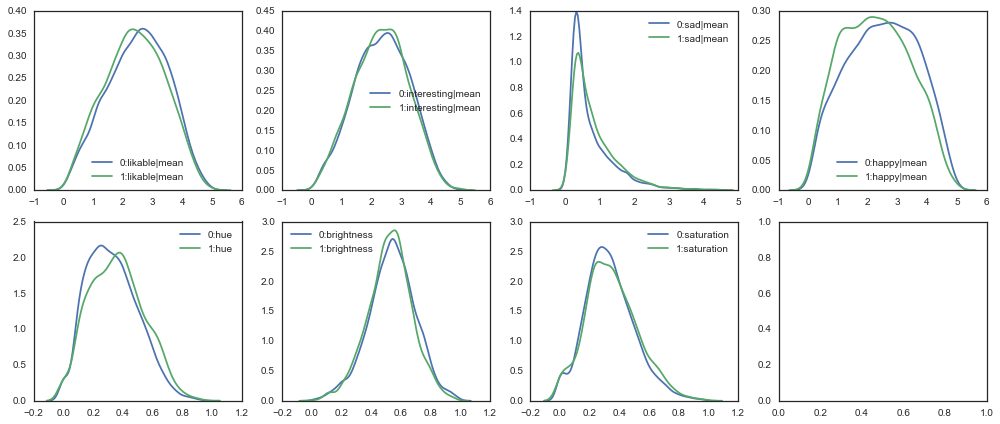

Correlation matrix:


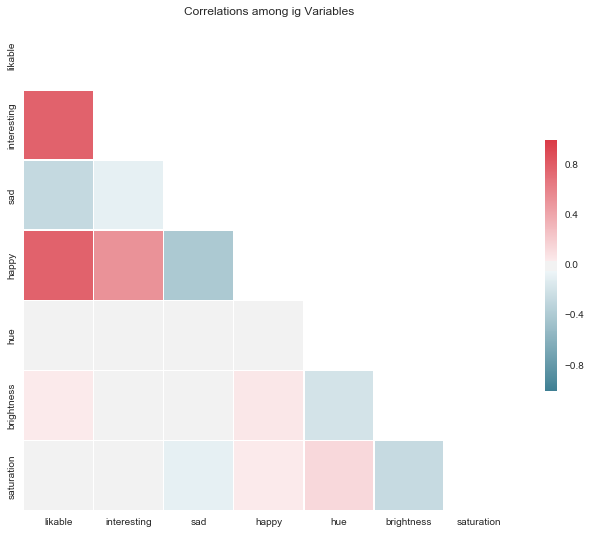

             likable  interesting   sad  happy   hue  brightness  saturation
likable         1.00         0.78 -0.27   0.78  0.00        0.04       -0.01
interesting     0.78         1.00 -0.08   0.52 -0.01        0.02       -0.02
sad            -0.27        -0.08  1.00  -0.40 -0.03       -0.02       -0.08
happy           0.78         0.52 -0.40   1.00  0.01        0.06        0.04
hue             0.00        -0.01 -0.03   0.01  1.00       -0.19        0.14
brightness      0.04         0.02 -0.02   0.06 -0.19        1.00       -0.26
saturation     -0.01        -0.02 -0.08   0.04  0.14       -0.26        1.00
UNIT OF MEASUREMENT: post

RATING: likable|mean
Ttest_indResult(statistic=5.0610735332340759, pvalue=4.2399725175202477e-07)

RATING: interesting|mean
Ttest_indResult(statistic=1.6488726562924223, pvalue=0.099203781984180742)

RATING: sad|mean
Ttest_indResult(statistic=-6.5856405789061192, pvalue=4.7468729884696595e-11)

RATING: happy|mean
Ttest_indResult(statistic=9.29010423166310

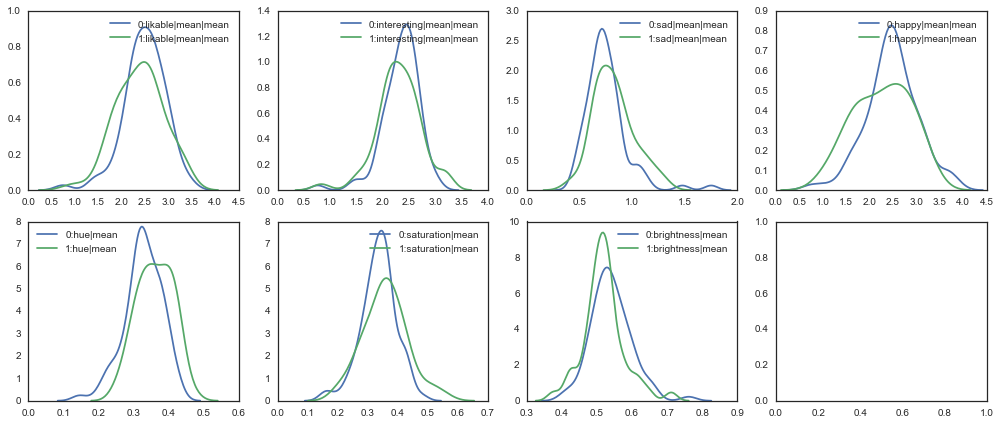

Correlation matrix:


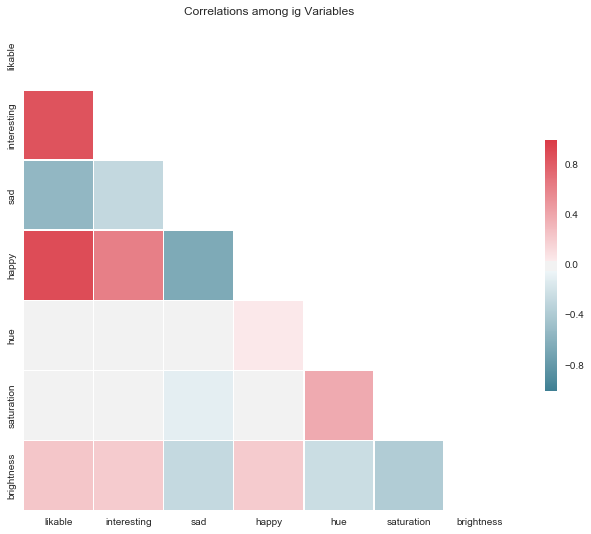

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.86 -0.54   0.90  0.01       -0.00        0.24
interesting     0.86         1.00 -0.28   0.62 -0.02       -0.02        0.21
sad            -0.54        -0.28  1.00  -0.65 -0.00       -0.10       -0.27
happy           0.90         0.62 -0.65   1.00  0.05        0.03        0.21
hue             0.01        -0.02 -0.00   0.05  1.00        0.39       -0.24
saturation     -0.00        -0.02 -0.10   0.03  0.39        1.00       -0.37
brightness      0.24         0.21 -0.27   0.21 -0.24       -0.37        1.00
UNIT OF MEASUREMENT: username

RATING: likable|mean|mean
Ttest_indResult(statistic=1.2743014957518335, pvalue=0.20481250322112654)

RATING: interesting|mean|mean
Ttest_indResult(statistic=0.65843482810032938, pvalue=0.51141430149568423)

RATING: sad|mean|mean
Ttest_indResult(statistic=-1.9415717232191394, pvalue=0.054335696814878473)

RATING: happy|mean|mean
Ttest_indResult(statist

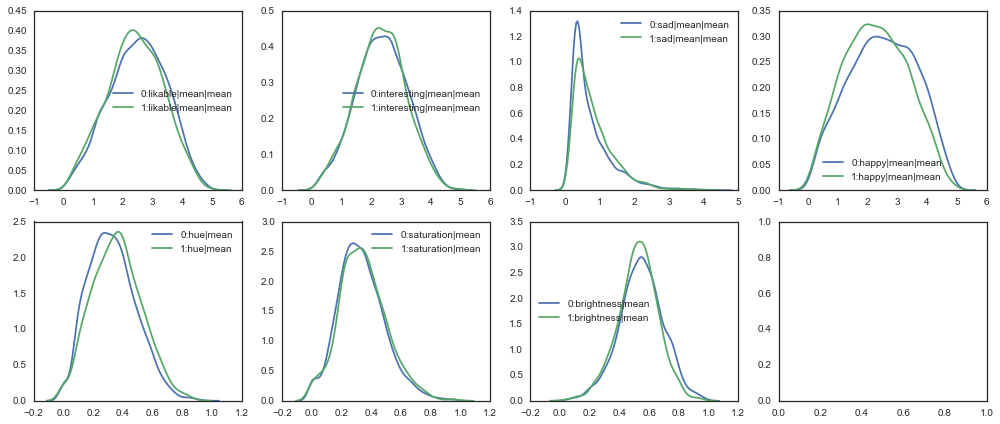

Correlation matrix:


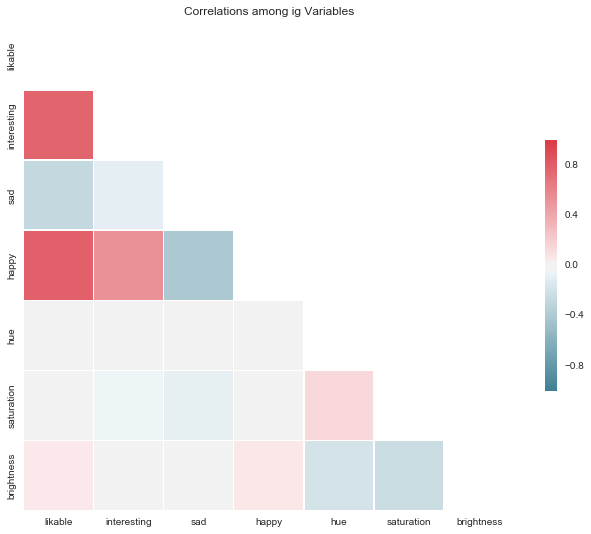

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.77 -0.28   0.79 -0.00       -0.02        0.05
interesting     0.77         1.00 -0.09   0.53 -0.03       -0.04        0.03
sad            -0.28        -0.09  1.00  -0.40 -0.03       -0.08       -0.03
happy           0.79         0.53 -0.40   1.00  0.02        0.03        0.06
hue            -0.00        -0.03 -0.03   0.02  1.00        0.14       -0.19
saturation     -0.02        -0.04 -0.08   0.03  0.14        1.00       -0.25
brightness      0.05         0.03 -0.03   0.06 -0.19       -0.25        1.00
UNIT OF MEASUREMENT: created_date

RATING: likable|mean|mean
Ttest_indResult(statistic=3.901208638495655, pvalue=9.6583118624528352e-05)

RATING: interesting|mean|mean
Ttest_indResult(statistic=1.729283763013844, pvalue=0.083801082037525107)

RATING: sad|mean|mean
Ttest_indResult(statistic=-4.7884481370235576, pvalue=1.7142577713684971e-06)

RATING: happy|mean|mean
Ttest_indResult(

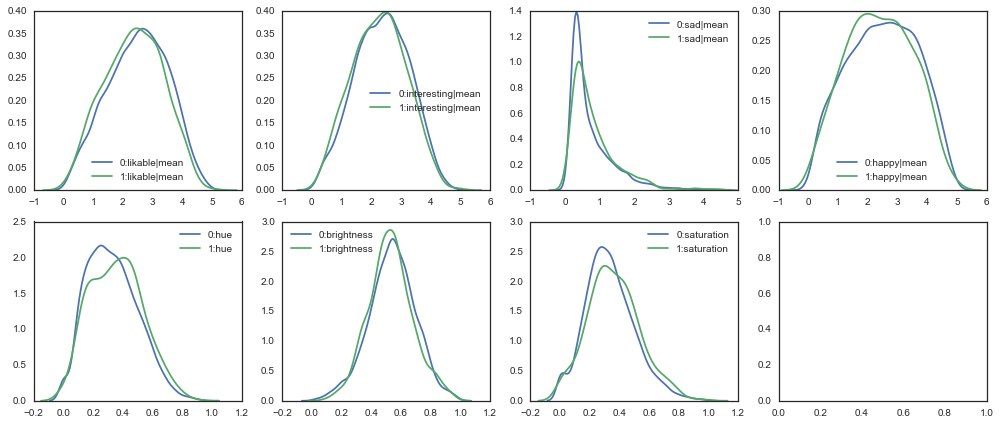

Correlation matrix:


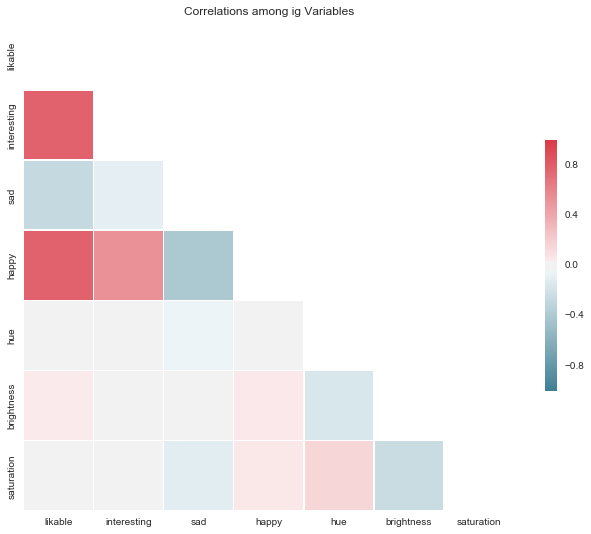

             likable  interesting   sad  happy   hue  brightness  saturation
likable         1.00         0.78 -0.27   0.78  0.01        0.04        0.02
interesting     0.78         1.00 -0.09   0.53  0.00        0.02        0.00
sad            -0.27        -0.09  1.00  -0.40 -0.05       -0.01       -0.11
happy           0.78         0.53 -0.40   1.00  0.03        0.05        0.06
hue             0.01         0.00 -0.05   0.03  1.00       -0.16        0.15
brightness      0.04         0.02 -0.01   0.05 -0.16        1.00       -0.25
saturation      0.02         0.00 -0.11   0.06  0.15       -0.25        1.00
UNIT OF MEASUREMENT: post

RATING: likable|mean
Ttest_indResult(statistic=3.5080118006380498, pvalue=0.00045402268824929875)

RATING: interesting|mean
Ttest_indResult(statistic=2.713342044340179, pvalue=0.00667551637229851)

RATING: sad|mean
Ttest_indResult(statistic=-3.3676056306384079, pvalue=0.00076192277340386802)

RATING: happy|mean
Ttest_indResult(statistic=2.1596054877882573

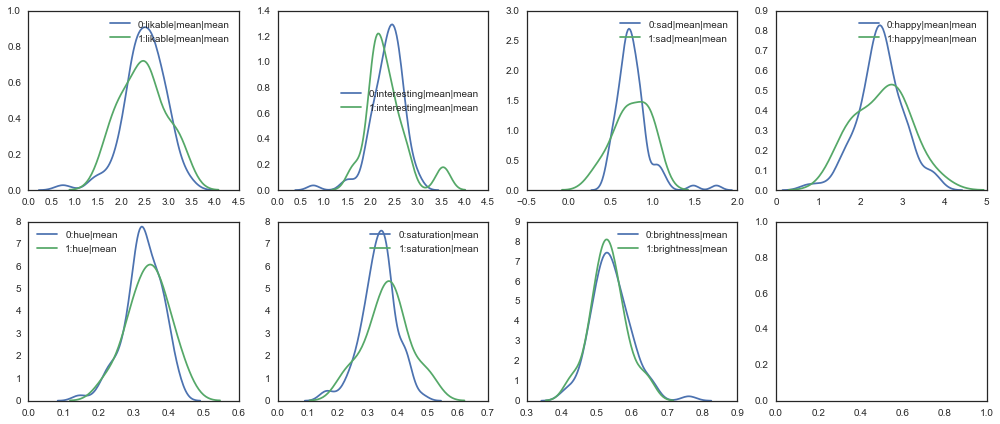

Correlation matrix:


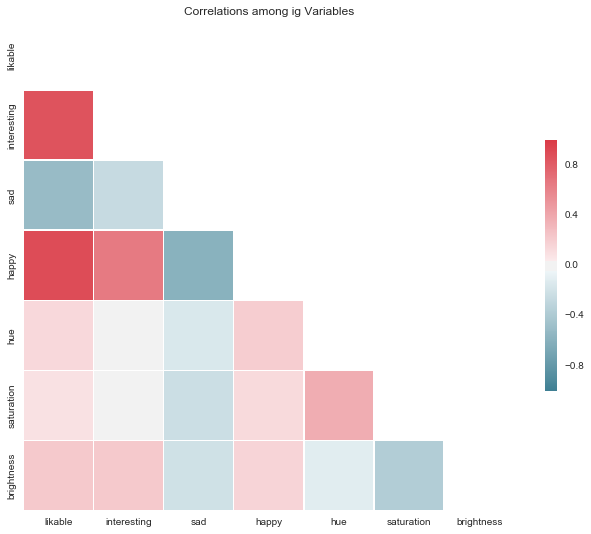

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.86 -0.51   0.90  0.14        0.09        0.22
interesting     0.86         1.00 -0.26   0.65  0.03        0.01        0.22
sad            -0.51        -0.26  1.00  -0.59 -0.15       -0.23       -0.21
happy           0.90         0.65 -0.59   1.00  0.20        0.13        0.16
hue             0.14         0.03 -0.15   0.20  1.00        0.37       -0.11
saturation      0.09         0.01 -0.23   0.13  0.37        1.00       -0.36
brightness      0.22         0.22 -0.21   0.16 -0.11       -0.36        1.00
UNIT OF MEASUREMENT: username

RATING: likable|mean|mean
Ttest_indResult(statistic=0.31800124502076876, pvalue=0.75118937753641224)

RATING: interesting|mean|mean
Ttest_indResult(statistic=0.13218652853556548, pvalue=0.89511929350541508)

RATING: sad|mean|mean
Ttest_indResult(statistic=0.13788971305250047, pvalue=0.89062252631801608)

RATING: happy|mean|mean
Ttest_indResult(statist

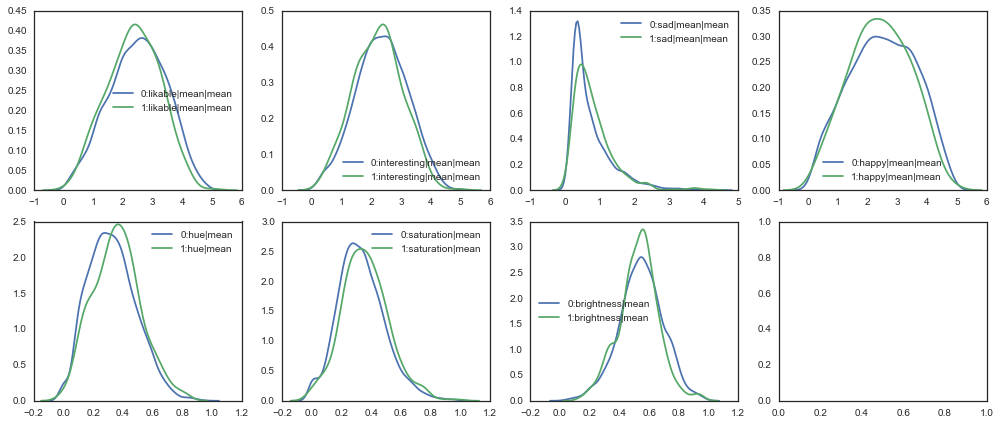

Correlation matrix:


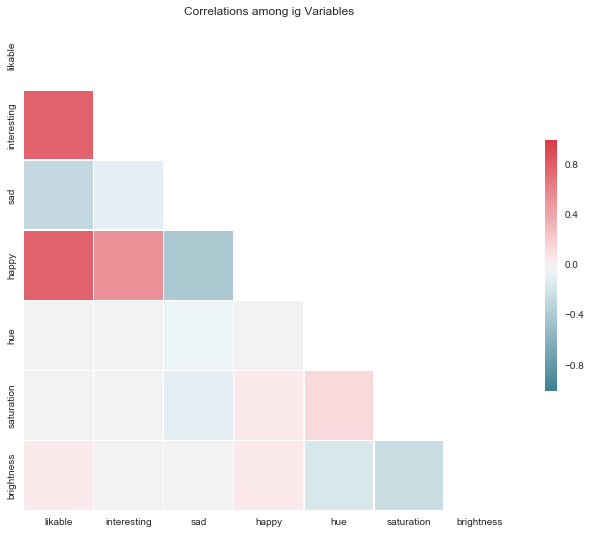

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.78 -0.28   0.78  0.02        0.00        0.04
interesting     0.78         1.00 -0.09   0.53 -0.01       -0.02        0.03
sad            -0.28        -0.09  1.00  -0.40 -0.04       -0.09       -0.02
happy           0.78         0.53 -0.40   1.00  0.03        0.04        0.05
hue             0.02        -0.01 -0.04   0.03  1.00        0.13       -0.16
saturation      0.00        -0.02 -0.09   0.04  0.13        1.00       -0.25
brightness      0.04         0.03 -0.02   0.05 -0.16       -0.25        1.00
UNIT OF MEASUREMENT: created_date

RATING: likable|mean|mean
Ttest_indResult(statistic=2.9387744038124026, pvalue=0.0033089786704583657)

RATING: interesting|mean|mean
Ttest_indResult(statistic=2.8877712220055964, pvalue=0.0038951214283419653)

RATING: sad|mean|mean
Ttest_indResult(statistic=-1.9316703025789419, pvalue=0.053452089227548662)

RATING: happy|mean|mean
Ttest_indResult(

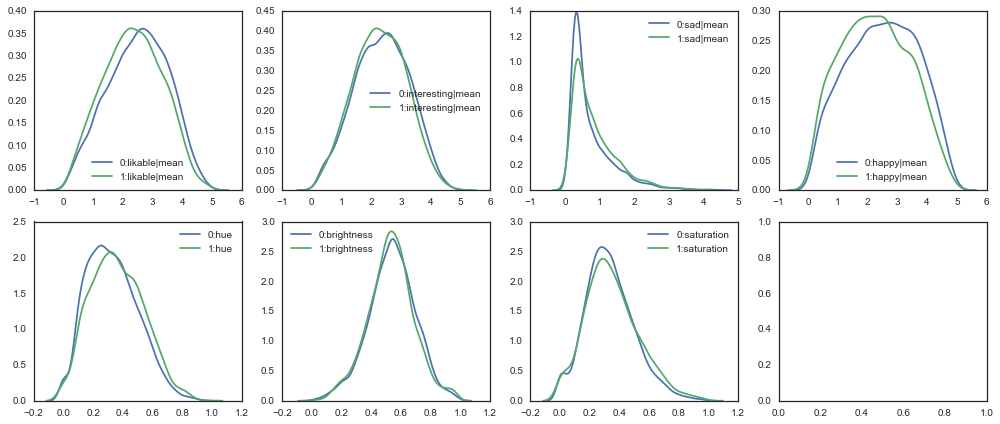

Correlation matrix:


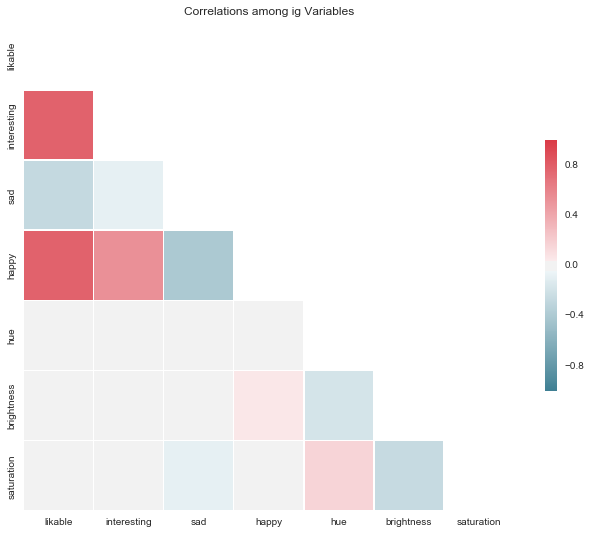

             likable  interesting   sad  happy   hue  brightness  saturation
likable         1.00         0.78 -0.27   0.78  0.00        0.03       -0.00
interesting     0.78         1.00 -0.08   0.53 -0.01        0.02       -0.01
sad            -0.27        -0.08  1.00  -0.40 -0.03       -0.02       -0.08
happy           0.78         0.53 -0.40   1.00  0.02        0.06        0.03
hue             0.00        -0.01 -0.03   0.02  1.00       -0.18        0.16
brightness      0.03         0.02 -0.02   0.06 -0.18        1.00       -0.26
saturation     -0.00        -0.01 -0.08   0.03  0.16       -0.26        1.00
UNIT OF MEASUREMENT: post

RATING: likable|mean
Ttest_indResult(statistic=7.4295010858533637, pvalue=1.1808215103792021e-13)

RATING: interesting|mean
Ttest_indResult(statistic=3.3451463056237198, pvalue=0.00082546978819954785)

RATING: sad|mean
Ttest_indResult(statistic=-6.5489581411728617, pvalue=6.0836940214173667e-11)

RATING: happy|mean
Ttest_indResult(statistic=9.049894117274

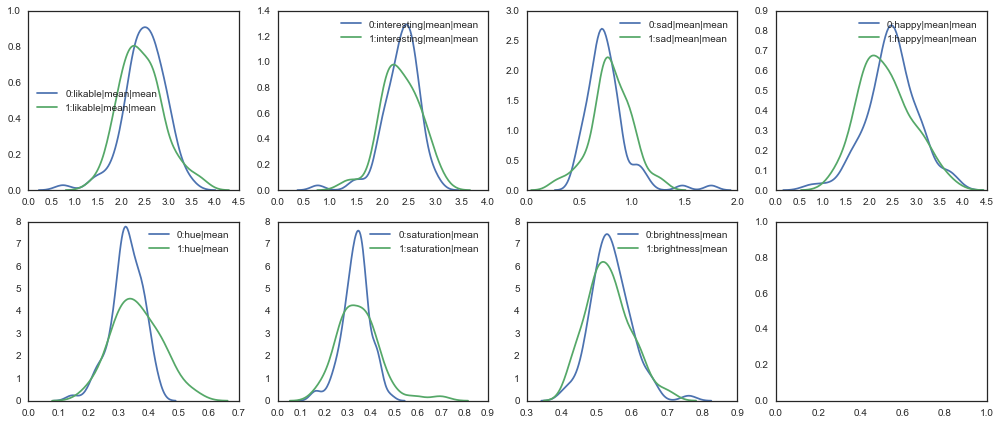

Correlation matrix:


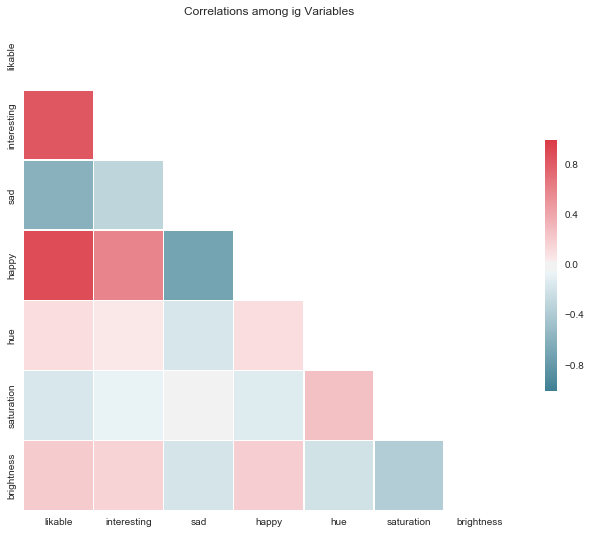

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.84 -0.60   0.90  0.11       -0.16        0.21
interesting     0.84         1.00 -0.30   0.60  0.06       -0.07        0.17
sad            -0.60        -0.30  1.00  -0.71 -0.17       -0.02       -0.18
happy           0.90         0.60 -0.71   1.00  0.11       -0.12        0.20
hue             0.11         0.06 -0.17   0.11  1.00        0.27       -0.20
saturation     -0.16        -0.07 -0.02  -0.12  0.27        1.00       -0.36
brightness      0.21         0.17 -0.18   0.20 -0.20       -0.36        1.00
UNIT OF MEASUREMENT: username

RATING: likable|mean|mean
Ttest_indResult(statistic=0.82119136654219349, pvalue=0.41304067122177879)

RATING: interesting|mean|mean
Ttest_indResult(statistic=0.10860833751481432, pvalue=0.91368060560422781)

RATING: sad|mean|mean
Ttest_indResult(statistic=-1.3042715948636898, pvalue=0.19444549856821289)

RATING: happy|mean|mean
Ttest_indResult(statist

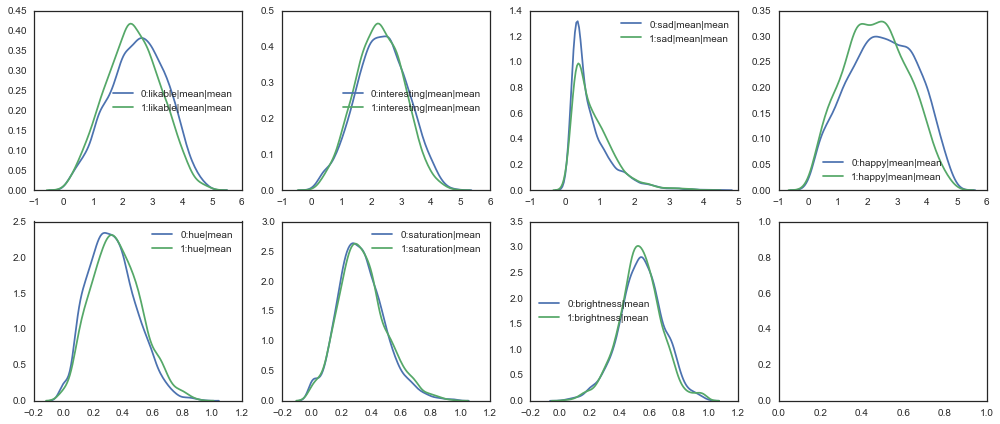

Correlation matrix:


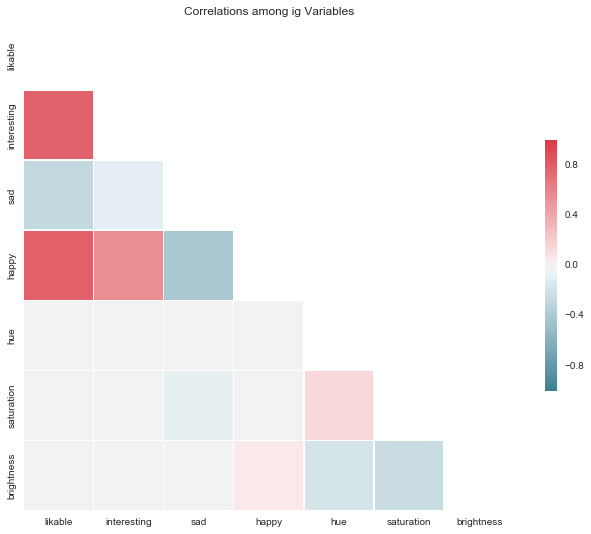

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.78 -0.28   0.79  0.01       -0.01        0.03
interesting     0.78         1.00 -0.09   0.54 -0.02       -0.03        0.02
sad            -0.28        -0.09  1.00  -0.41 -0.03       -0.08       -0.03
happy           0.79         0.54 -0.41   1.00  0.03        0.03        0.05
hue             0.01        -0.02 -0.03   0.03  1.00        0.14       -0.18
saturation     -0.01        -0.03 -0.08   0.03  0.14        1.00       -0.25
brightness      0.03         0.02 -0.03   0.05 -0.18       -0.25        1.00
UNIT OF MEASUREMENT: created_date

RATING: likable|mean|mean
Ttest_indResult(statistic=6.2555122868621309, pvalue=4.2028497173266088e-10)

RATING: interesting|mean|mean
Ttest_indResult(statistic=3.4472325342811665, pvalue=0.00056979403554850672)

RATING: sad|mean|mean
Ttest_indResult(statistic=-5.009608081955145, pvalue=5.5918234983680641e-07)

RATING: happy|mean|mean
Ttest_indResu

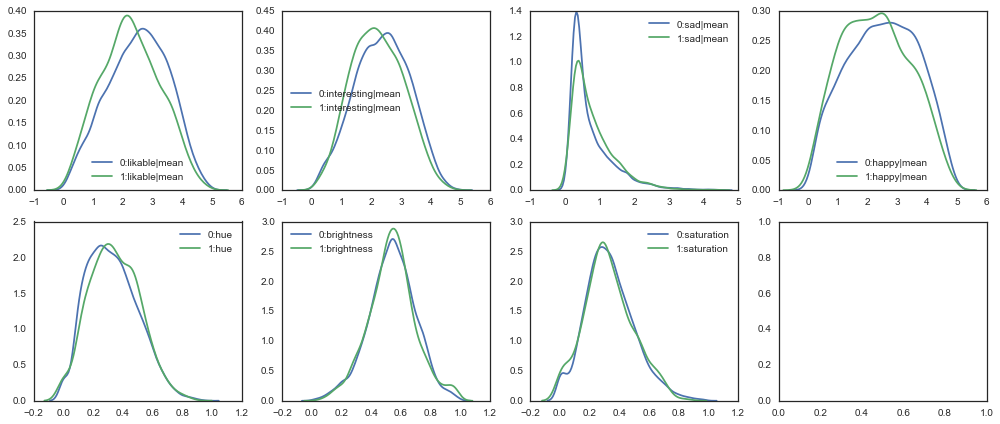

Correlation matrix:


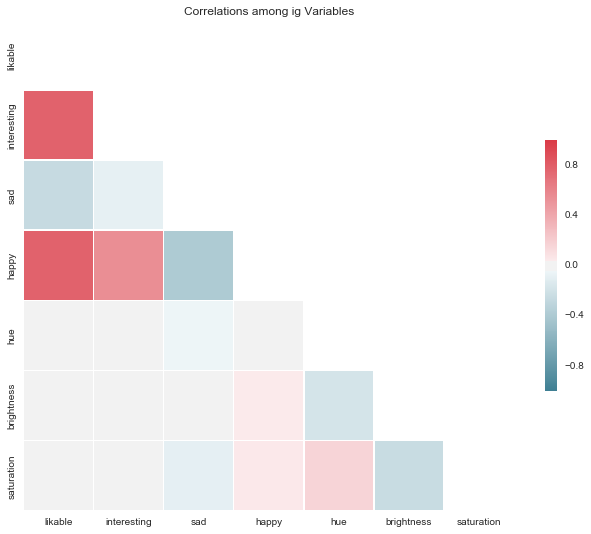

             likable  interesting   sad  happy   hue  brightness  saturation
likable         1.00         0.78 -0.26   0.78  0.01        0.03        0.01
interesting     0.78         1.00 -0.08   0.54 -0.01        0.02       -0.01
sad            -0.26        -0.08  1.00  -0.39 -0.04       -0.02       -0.09
happy           0.78         0.54 -0.39   1.00  0.03        0.04        0.05
hue             0.01        -0.01 -0.04   0.03  1.00       -0.18        0.16
brightness      0.03         0.02 -0.02   0.04 -0.18        1.00       -0.25
saturation      0.01        -0.01 -0.09   0.05  0.16       -0.25        1.00
UNIT OF MEASUREMENT: post

RATING: likable|mean
Ttest_indResult(statistic=7.6736066473917051, pvalue=1.8630528776442157e-14)

RATING: interesting|mean
Ttest_indResult(statistic=5.2311329717922295, pvalue=1.7261133191913183e-07)

RATING: sad|mean
Ttest_indResult(statistic=-3.2805283218057277, pvalue=0.0010404260413522199)

RATING: happy|mean
Ttest_indResult(statistic=6.0861894653492

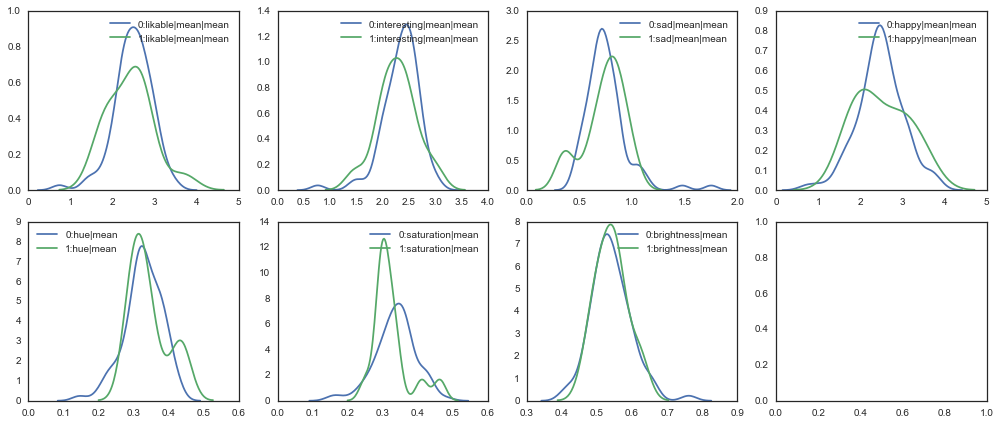

Correlation matrix:


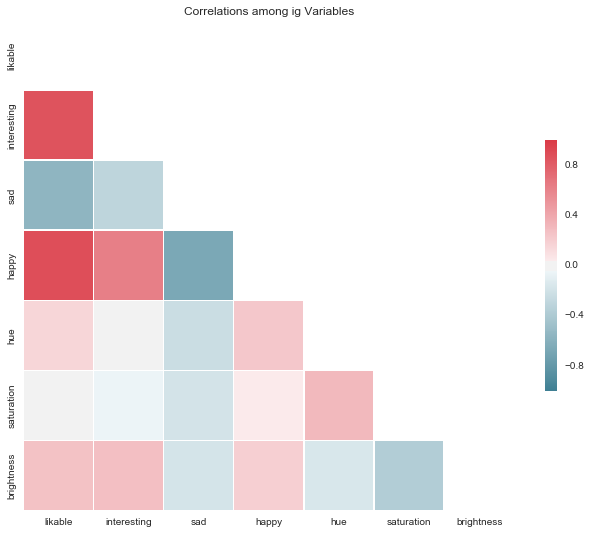

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.86 -0.56   0.89  0.15       -0.01        0.26
interesting     0.86         1.00 -0.30   0.62  0.01       -0.05        0.28
sad            -0.56        -0.30  1.00  -0.67 -0.24       -0.19       -0.18
happy           0.89         0.62 -0.67   1.00  0.23        0.04        0.19
hue             0.15         0.01 -0.24   0.23  1.00        0.31       -0.16
saturation     -0.01        -0.05 -0.19   0.04  0.31        1.00       -0.36
brightness      0.26         0.28 -0.18   0.19 -0.16       -0.36        1.00
UNIT OF MEASUREMENT: username

RATING: likable|mean|mean
Ttest_indResult(statistic=0.47814145687178861, pvalue=0.63365965771442667)

RATING: interesting|mean|mean
Ttest_indResult(statistic=0.76571098578595453, pvalue=0.44576671926904798)

RATING: sad|mean|mean
Ttest_indResult(statistic=0.29988916114609249, pvalue=0.76492385421239817)

RATING: happy|mean|mean
Ttest_indResult(statist

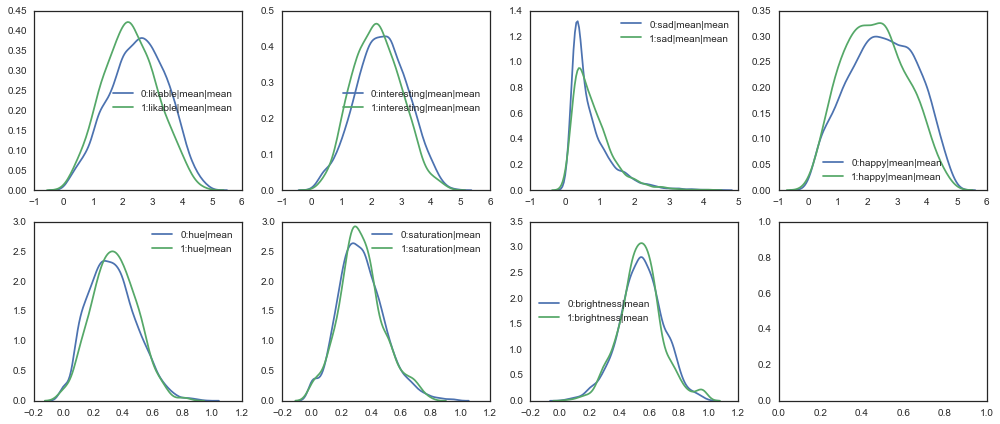

Correlation matrix:


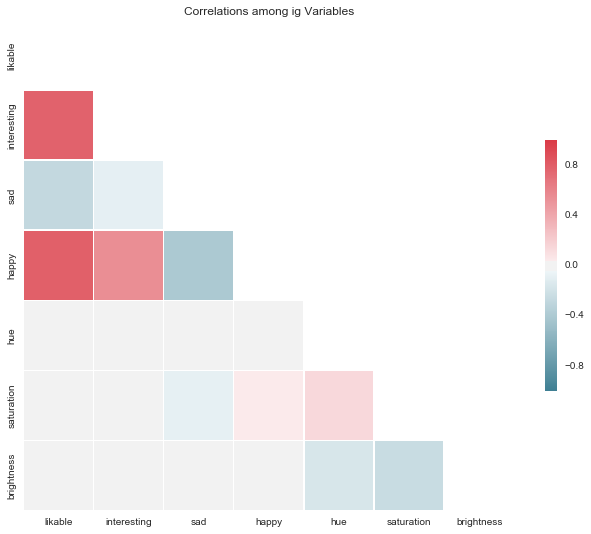

             likable  interesting   sad  happy   hue  saturation  brightness
likable         1.00         0.78 -0.28   0.79  0.01        0.00        0.03
interesting     0.78         1.00 -0.09   0.54 -0.02       -0.02        0.03
sad            -0.28        -0.09  1.00  -0.40 -0.03       -0.08       -0.02
happy           0.79         0.54 -0.40   1.00  0.03        0.04        0.03
hue             0.01        -0.02 -0.03   0.03  1.00        0.14       -0.17
saturation      0.00        -0.02 -0.08   0.04  0.14        1.00       -0.25
brightness      0.03         0.03 -0.02   0.03 -0.17       -0.25        1.00
UNIT OF MEASUREMENT: created_date

RATING: likable|mean|mean
Ttest_indResult(statistic=7.0233034053082983, pvalue=2.4162908569983394e-12)

RATING: interesting|mean|mean
Ttest_indResult(statistic=4.8560632292945494, pvalue=1.2289872887488676e-06)

RATING: sad|mean|mean
Ttest_indResult(statistic=-2.604433727146986, pvalue=0.0092262032994059606)

RATING: happy|mean|mean
Ttest_indResul

In [14]:
for period in periods: # before, after (<key_date>)
    for turn_point in turn_points:  # diag_date, susp_date
        
        data['master'][period] = {turn_point:{}}
        master = data['master'][period][turn_point]
        target = data['target'][period][turn_point]['gb']
        control = data['control']['gb'] 
        m = platform
        report = '{} {}'.format(period,turn_point)
        
        # merge target, control, into master
        master_actions(master, target, control, condition,
                       platform, params, gb_types, report,
                       save_to_file, density, corr, ml, nhst)

### Within-target before vs after


before vs after (target: depression) for post-groupby, based on diag_date:


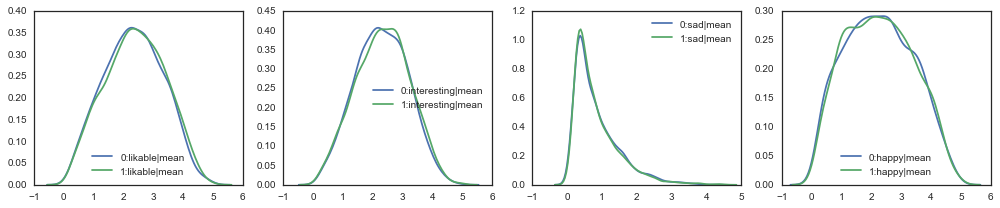

UNIT OF MEASUREMENT: post

RATING: likable|mean
Ttest_indResult(statistic=-2.3769707003364156, pvalue=0.017486255688012219)

RATING: interesting|mean
Ttest_indResult(statistic=-1.6003342441817596, pvalue=0.10957643477944445)

RATING: sad|mean
Ttest_indResult(statistic=0.32873603640567062, pvalue=0.7423665410173621)

RATING: happy|mean
Ttest_indResult(statistic=-0.3774986287974611, pvalue=0.70581626606620451)

RATING: hue
Ttest_indResult(statistic=-0.071714605434512288, pvalue=0.94283139257341864)

RATING: brightness
Ttest_indResult(statistic=1.6604693568391637, pvalue=0.09687165759177814)

RATING: saturation
Ttest_indResult(statistic=0.14909907463104488, pvalue=0.88148040348089318)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean significant post-correction? False (0.122403789816)
interesting|mean significant post-correction? False (0.767035043456)
sad|mean significant post-correction? False (1.0)
happy|mean significant post-correction? False (1.0)
hue significant pos

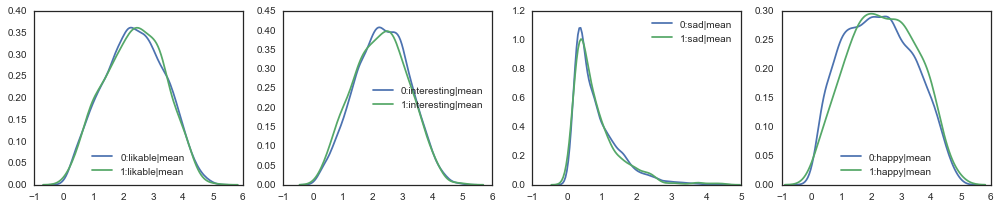

UNIT OF MEASUREMENT: post

RATING: likable|mean
Ttest_indResult(statistic=0.24201385394376548, pvalue=0.8087775946441953)

RATING: interesting|mean
Ttest_indResult(statistic=1.6145690329061948, pvalue=0.10645597171878945)

RATING: sad|mean
Ttest_indResult(statistic=0.14896530667375452, pvalue=0.88158595160913156)

RATING: happy|mean
Ttest_indResult(statistic=-3.1025065746573142, pvalue=0.00192769618993132)

RATING: hue
Ttest_indResult(statistic=0.62342387252275477, pvalue=0.53302941142565374)

RATING: brightness
Ttest_indResult(statistic=-0.3267531909170574, pvalue=0.74386581902171456)

RATING: saturation
Ttest_indResult(statistic=-1.7611687497874544, pvalue=0.078260129726297353)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean significant post-correction? False (1.0)
interesting|mean significant post-correction? False (0.745191802032)
sad|mean significant post-correction? False (1.0)
happy|mean significant post-correction? True (0.0134938733295)
hue significant post-

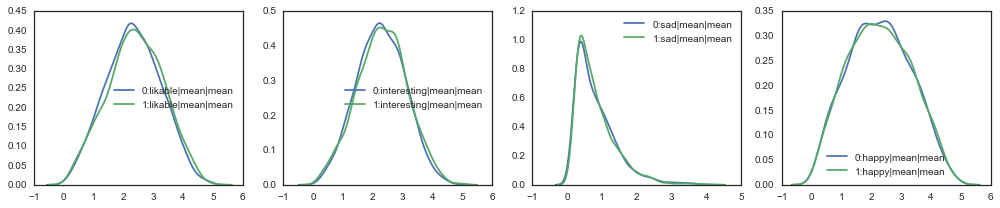

UNIT OF MEASUREMENT: created_date

RATING: likable|mean|mean
Ttest_indResult(statistic=-2.317540079269369, pvalue=0.020525372426048259)

RATING: interesting|mean|mean
Ttest_indResult(statistic=-1.6322470262671029, pvalue=0.10270745073898813)

RATING: sad|mean|mean
Ttest_indResult(statistic=0.55556889106904062, pvalue=0.57853717816565198)

RATING: happy|mean|mean
Ttest_indResult(statistic=-0.1959196749082773, pvalue=0.84468315109025516)

RATING: hue|mean
Ttest_indResult(statistic=-0.43953657417602671, pvalue=0.66029691716383632)

RATING: saturation|mean
Ttest_indResult(statistic=-0.61291380499322135, pvalue=0.53996874608941103)

RATING: brightness|mean
Ttest_indResult(statistic=3.1546716040304696, pvalue=0.0016188989439830288)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean|mean significant post-correction? False (0.143677606982)
interesting|mean|mean significant post-correction? False (0.718952155173)
sad|mean|mean significant post-correction? False (1.0)
happy|mean|

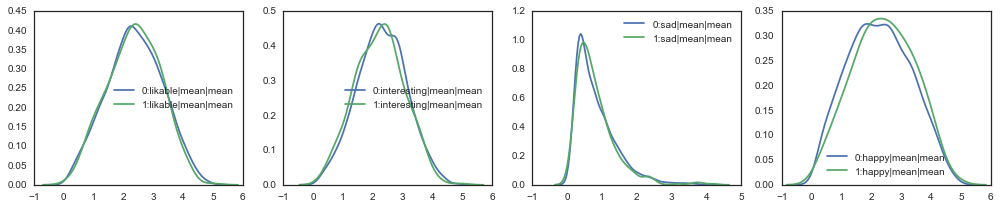

UNIT OF MEASUREMENT: created_date

RATING: likable|mean|mean
Ttest_indResult(statistic=0.43192818122138471, pvalue=0.66581727106072308)

RATING: interesting|mean|mean
Ttest_indResult(statistic=1.8345169120027165, pvalue=0.066652738248376281)

RATING: sad|mean|mean
Ttest_indResult(statistic=0.63948831034237141, pvalue=0.52254253193649791)

RATING: happy|mean|mean
Ttest_indResult(statistic=-2.5088129495827434, pvalue=0.01215364402999785)

RATING: hue|mean
Ttest_indResult(statistic=0.0083718306526015633, pvalue=0.99332074787815561)

RATING: saturation|mean
Ttest_indResult(statistic=-2.1556594353982534, pvalue=0.031170698720719148)

RATING: brightness|mean
Ttest_indResult(statistic=0.41775848565663765, pvalue=0.67614649399576443)

bonferroni-corrected alpha of 0.05: 0.00714285714286
likable|mean|mean significant post-correction? False (1.0)
interesting|mean|mean significant post-correction? False (0.466569167739)
sad|mean|mean significant post-correction? False (1.0)
happy|mean|mean signif

In [15]:
# no username gb because you don't have the infrastructure built (you'd need to split bef/aft before the username gb)
# but at any rate, this is just a check...and per-username groupby has the lowest sample size anyhow

for gb_type in ['post','created_date']: 
    before_vs_after(data['target']['gb'], gb_type, condition, params)